# Lorenz63 example

Note: The packages for this example are documented in the [Project.toml](Project.toml),
      except for some unregistered packages.

First, we'll set up the environment, which entails installing and importing packages.

In [1]:
# Install unregistered packages.
using Pkg: Pkg

using Ensembles
try
    using Lorenz63: Lorenz63
catch
    Ensembles.install(:Lorenz63)
end

try
    using EnsembleKalmanFilters: EnsembleKalmanFilters
catch
    Ensembles.install(:EnsembleKalmanFilters)
end

try
    using NormalizingFlowFilters: NormalizingFlowFilters
catch
    Ensembles.install(:NormalizingFlowFilters)
end

# Define a macro for doing imports to avoid duplicating it for remote processes later on.
macro initial_imports()
    return esc(
        quote
            using Ensembles
            using LinearAlgebra: norm
            using Distributed: addprocs, rmprocs, @everywhere, remotecall, fetch, WorkerPool
            using Test: @test
            using Random: Random
            using CairoMakie

            using Lorenz63: Lorenz63
            ext = Base.get_extension(Ensembles, :Lorenz63Ext)
            using .ext

            using EnsembleKalmanFilters: EnsembleKalmanFilters
            ext = Base.get_extension(Ensembles, :EnsembleKalmanFiltersExt)
            using .ext

            using Statistics: Statistics, mean, var
            using LinearAlgebra: Diagonal
            using EnsembleKalmanFilters: EnKF
        end
    )
end

@initial_imports
worker_initial_imports = @macroexpand1 @initial_imports

include("../_utils/utils.jl");

    Updating git-repo `https://github.com/milankl/Lorenz63.jl#15220a7`
   Resolving package versions...
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Project.toml`
  [72db8b11] + Lorenz63 v0.1.0 `https://github.com/milankl/Lorenz63.jl#15220a7#master`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Manifest.toml`
  [72db8b11] + Lorenz63 v0.1.0 `https://github.com/milankl/Lorenz63.jl#15220a7#master`
    Updating git-repo `https://github.com/DataAssimilation/EnsembleKalmanFilters.jl`
   Resolving package versions...
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Project.toml`
  [489b957c] + EnsembleKalmanFilters v0.0.1 `https://github.com/DataAssimilation/EnsembleKalmanFilters.jl#main`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Manifest.toml`
  [489b957c] + EnsembleKalmanFilters v0.0.1 `https://github.com/DataAssimilation/EnsembleKalmanFilters.jl#main`
    Updating git-repo `https://github.com/DataAssimilation/Nor

Define parameters.

In [2]:
params = Dict(
    "format" => "v0.1",
    "transition" => Dict(
        "sigma" => 10,
        "rho" => 28,
        "beta" => 8 / 3,
        "scaling" => 1,
        "ministep_nt" => missing,
        "ministep_dt" => 0.05,
    ),
    "observation" =>
        Dict("noise_scale" => 2, "timestep_size" => 0.1, "num_timesteps" => 300),
    "ensemble" => Dict(
        "size" => 10,
        "seed" => 9347215,
        "prior" => "gaussian",
        "prior_params" => [0.0, 1.0],
    ),
    "spinup" => Dict(
        "num_timesteps" => 300,
        "transition_noise_scale" => 1.0,

        # EnKF params
        "algorithm" => "enkf",
        "include_noise_in_y_covariance" => true,
        "multiplicative_prior_inflation" => 0.0,
        "observation_noise_stddev" => 2.0,
        "observation_noise_type" => "diagonal",
    ),
);

Seed for reproducibility.

In [3]:
Random.seed!(1983745);

Make operators.

In [4]:
transitioner = Lorenz63Model(; params)
observer = NoisyObserver(get_state_keys(transitioner); params);

Set seed for ground-truth simulation.

In [5]:
Random.seed!(0xfee55e45)
xor_seed!(observer, UInt64(0x243ecae5));

Define observation times

In [6]:
observation_times = let
    step = params["observation"]["timestep_size"]
    length = params["observation"]["num_timesteps"]
    range(; start=0, length, step)
end

0.0:0.1:29.9

Generate synthetic ground-truth observations.

In [7]:
if !(@isdefined ground_truth) || isnothing(ground_truth)
    ground_truth = @time let
        state0 = Dict{Symbol,Any}(:state => randn(3))

        # Set seed for ground-truth simulation.
        Random.seed!(0xfee55e45)
        xor_seed!(observer, UInt64(0x243ecae5))

        # Generate states and observations.
        t0 = 0.0
        states = Vector{Dict{Symbol,Any}}(undef, length(observation_times))
        observations = Vector{Dict{Symbol,Any}}(undef, length(observation_times))
        let state = state0
            for (i, t) in enumerate(observation_times)
                state = transitioner(state, t0, t)
                obs = observer(state)
                states[i] = state
                observations[i] = split_clean_noisy(observer, obs)[2]
                t0 = t
            end
        end
        (; states, observations)
    end
    println("  ^ timing for making ground truth observations")
    ground_truth_states_vec = get_ensemble_matrix([:state], ground_truth.states)
    ground_truth_obs_vec = get_ensemble_matrix([:state], ground_truth.observations)
end;

  0.003498 seconds (45.96 k allocations: 2.461 MiB)
  ^ timing for making ground truth observations


Plot the ground-truth.

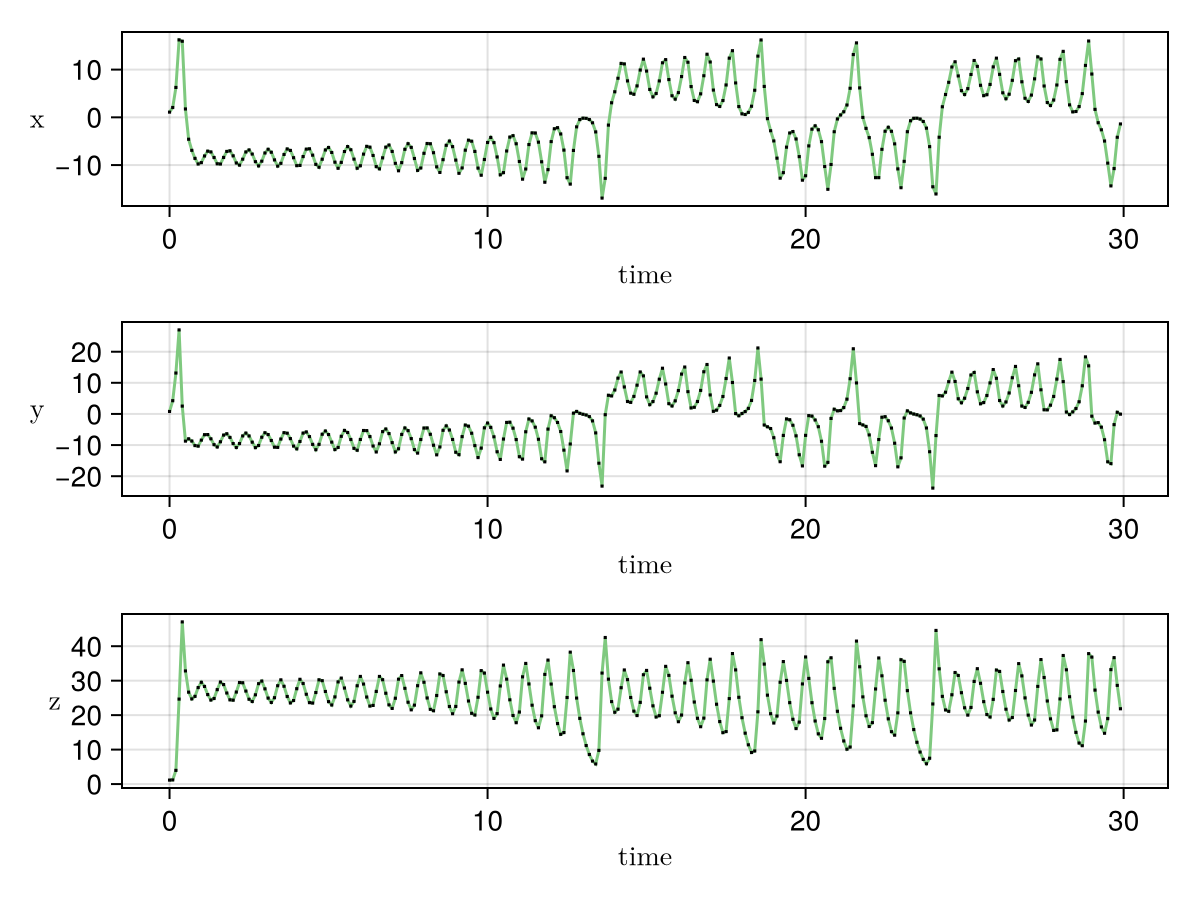

In [8]:
if !(@isdefined plot_ground_truth)
    plot_ground_truth = true
end
if plot_ground_truth
    figs = let
        ts = observation_times
        data = reduce(hcat, state[:state] for state in ground_truth.states)

        plot_kwargs = (; color="#7fc97f", marker='.', markersize=15, markercolor=:black)
        plot_state_over_time(observation_times, data; plot_kwargs...)
    end
    figs[1]
end

# Ensembles

Make initial ensemble.

In [9]:
function generate_ensemble(params::Dict)
    seed = params["ensemble"]["seed"]
    ensemble_size = params["ensemble"]["size"]
    prior_type = params["ensemble"]["prior"]

    members = Vector{Dict{Symbol,Any}}(undef, ensemble_size)
    if prior_type == "gaussian"
        rng = Random.MersenneTwister(seed)
        prior_mean, prior_std = params["ensemble"]["prior_params"]
        for i in 1:ensemble_size
            data = prior_mean .+ prior_std .* randn(rng, 3)
            state = Dict{Symbol,Any}(:state => data)
            members[i] = state
        end
    else
        throw(ArgumentError("Invalid prior type: $prior_type"))
    end

    ensemble = Ensemble(members)
    return ensemble
end

if !(@isdefined ensemble_initial0) || isnothing(ensemble_initial0)
    ensemble_initial0 = generate_ensemble(params)
end

ensemble_initial0 = generate_ensemble(params);
ensemble_initial = Ensemble(ensemble_initial0, ensemble_initial0.members, [:state]);

t_index_end = params["spinup"]["num_timesteps"]
observation_times = observation_times[1:t_index_end]
ground_truth_observations = ground_truth.observations[1:t_index_end]
transition_noise = params["spinup"]["transition_noise_scale"];

# Data assimilation

Choose filtering algorithm.

In [10]:
filter = get_enkf_filter(params["spinup"])

EnsembleKalmanFilters.EnKF([4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], true, 0.0)

Run sequential algorithm.

In [11]:
if !(@isdefined ensembles) || isnothing(ensembles)
    ensembles =
        let t_index_end = params["spinup"]["num_timesteps"],
            observation_times = observation_times[1:t_index_end],
            ground_truth_observations = ground_truth.observations[1:t_index_end],
            ensemble = ensemble_initial0,
            t0 = 0.0,
            transition_noise = params["spinup"]["transition_noise_scale"]

            Random.seed!(0x3289745)
            xor_seed!(observer, UInt64(0x375ef928))

            logs = []
            ensembles = []
            @time begin
                push!(ensembles, (; ensemble, t=t0))
                for (t, y_obs) in zip(observation_times, ground_truth_observations)
                    # Advance ensemble to time t.
                    ensemble = transitioner(ensemble, t0, t; inplace=false)

                    # Keep ensemble separated.
                    if transition_noise != 0
                        for em in ensemble.members
                            em[:state] .+= transition_noise .* Random.randn(3)
                        end
                    end

                    # Take observation at time t.
                    ensemble_obs = observer(ensemble)
                    ensemble_obs_clean, ensemble_obs_noisy = split_clean_noisy(
                        observer, ensemble_obs
                    )

                    # Record.
                    push!(
                        ensembles, (; ensemble, ensemble_obs_clean, ensemble_obs_noisy, t)
                    )

                    # Assimilate observation
                    log_data = Dict{Symbol,Any}()
                    (posterior, timing...) = @timed assimilate_data(
                        filter,
                        ensemble,
                        ensemble_obs_clean,
                        ensemble_obs_noisy,
                        y_obs,
                        log_data,
                    )
                    log_data[:timing] = timing
                    ensemble = posterior

                    # Record.
                    push!(ensembles, (; ensemble, t))
                    push!(logs, log_data)

                    # Let time pass.
                    t0 = t
                end
            end
            println("  ^ timing for making initial ensemble")
            ensembles
        end
end;

  4.904106 seconds (6.62 M allocations: 1.215 GiB, 3.15% gc time)
  ^ timing for making initial ensemble


Define handy functions.

In [12]:
function get_ground_truth_iterator(ensembles_ts, observation_times)
    gt_index = 1
    gt_indices = []
    post_assim_indices = []
    for (i, t) in enumerate(ensembles_ts)
        while gt_index <= length(observation_times) && observation_times[gt_index] < t
            gt_index += 1
        end
        if gt_index > length(observation_times)
            error(
                "Comparing at time $(t) is impossible because final ground-truth observation is at time $(observation_times[end])",
            )
        end
        if observation_times[gt_index] != t
            error(
                "No observation at time $(t). Closest are $(observation_times[gt_index-1]) and $(observation_times[gt_index])",
            )
        end
        push!(gt_indices, gt_index)
        if i == length(ensembles_ts) || t < ensembles_ts[i + 1]
            push!(post_assim_indices, i)
        end
    end
    return gt_indices, post_assim_indices
end

function compute_errors(gt_indices, ensembles_means_vec, ground_truth_states_vec)
    rmses = Vector{Float64}(undef, length(ensembles_means_vec))
    for (i, gt_index) in enumerate(gt_indices)
        rmses[i] = rmse(ensembles_means_vec[:, i], ground_truth_states_vec[:, gt_index])
    end
    return rmses
end

function compute_metrics(ensembles)
    means_vec = get_ensemble_matrix(
        ensembles[1].ensemble.state_keys, mean(e.ensemble) for e in ensembles
    )
    vars_vec = get_ensemble_matrix(
        ensembles[1].ensemble.state_keys, var(e.ensemble) for e in ensembles
    )
    ts = [e.t for e in ensembles]

    gt_indices, post_assim_indices = get_ground_truth_iterator(ts, observation_times)
    rmses = compute_errors(gt_indices, means_vec, ground_truth_states_vec)

    spread = sqrt.(mean(vars_vec; dims=1)[1, :])
    return (;
        ts,
        vars_vec,
        means_vec,
        gt_indices,
        post_assim_indices,
        rmses,
        spread,
        post_assim_rmses=(rmses[i] for i in post_assim_indices),
        post_assim_spread=(spread[i] for i in post_assim_indices),
    )
end;

Compute metrics.

In [13]:
metrics_initial = compute_metrics(ensembles)

println("SPINUP")
println("  Average metrics")
println("      RMSE: $(mean(metrics_initial.post_assim_rmses))")
println("    Spread: $(mean(metrics_initial.post_assim_spread))")
println()

println("Observations")
println("  Average metrics")
println("      RMSE: $(mean(rmse.(ground_truth_obs_vec, ground_truth_states_vec)))")
println()

SPINUP
  Average metrics
      RMSE: 0.94082500434391
    Spread: 1.049306132209731

Observations
  Average metrics
      RMSE: 1.6076413581833835



Plot metrics over time

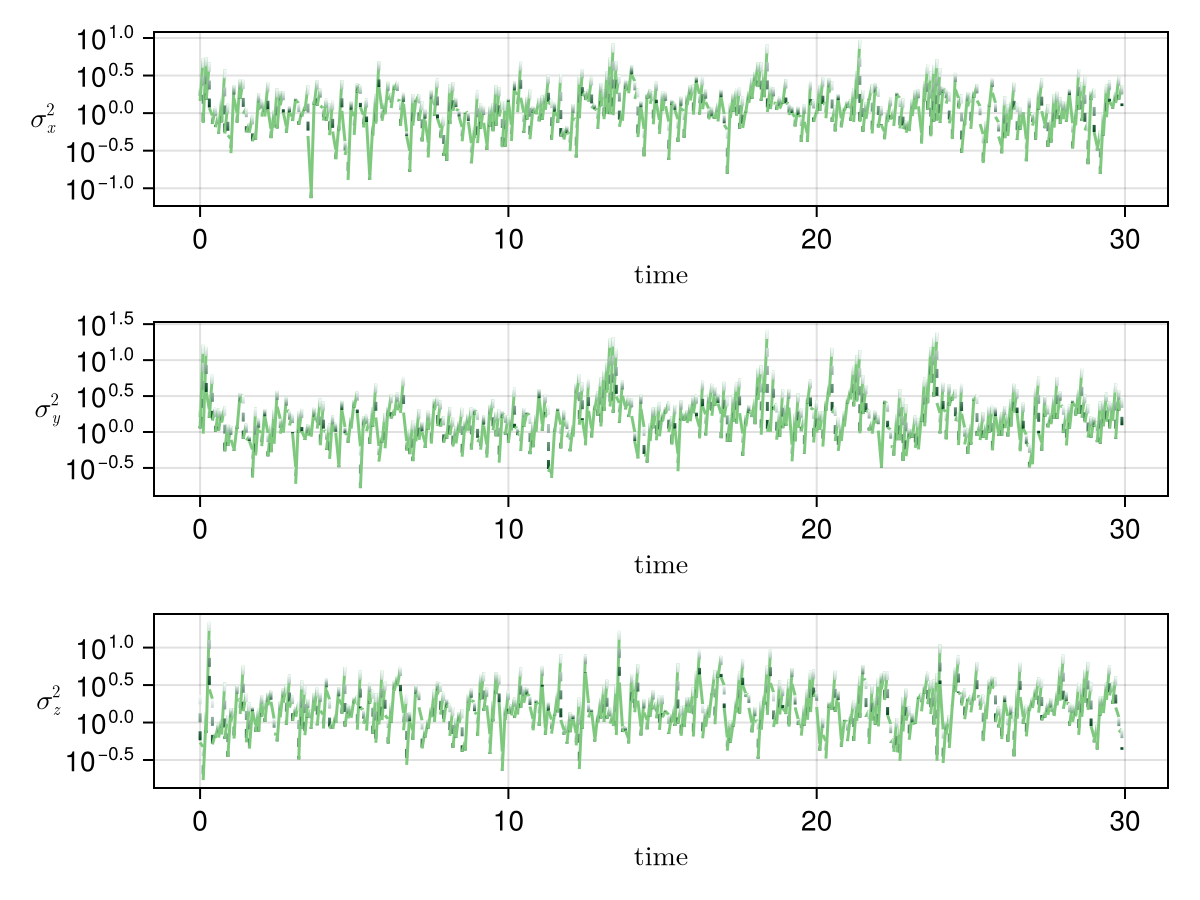

In [14]:
if !(@isdefined plot_initial_metrics)
    plot_initial_metrics = true
end
if plot_initial_metrics
    figs_state, figs_spread, figs_rmse = let metrics = metrics_initial
        cut = Colon()

        # Plot variance.
        handler = function (fig)
            for ax in fig.content
                if isa(ax, Axis)
                    if ax.ylabel[] == L"\text{x}"
                        ax.ylabel = L"\sigma^2_x"
                        ax.yscale = log10
                    elseif ax.ylabel[] == L"\text{y}"
                        ax.ylabel = L"\sigma^2_y"
                        ax.yscale = log10
                    elseif ax.ylabel[] == L"\text{z}"
                        ax.ylabel = L"\sigma^2_z"
                        ax.yscale = log10
                    end
                end
            end
        end
        plot_kwargs = (;
            handler,
            max_dt=50,
            make_positive=true,
            color="#7fc97f",
            marker='.',
            markersize=0,
            markercolor=:black,
            connect=(; linestyle=:dash, color=[1, 2], colormap=:BuGn, markersize=0),
        )
        figs_state = plot_state_over_time(
            metrics.ts[cut], metrics.vars_vec[:, cut]; plot_kwargs...
        )

        # Plot ensemble spread.
        handler = function (fig)
            for ax in fig.content
                if isa(ax, Axis)
                    if ax.ylabel[] == L"\text{metric}"
                        ax.ylabel = L"\text{spread}"
                        ax.yscale = log10
                    end
                end
            end
        end
        plot_kwargs = (;
            handler,
            max_dt=50,
            color="#041a1c",
            marker='.',
            markersize=15,
            markercolor=:black,
            connect=(; linestyle=:dash, color=[1, 2], colormap=:BuGn, markersize=0),
        )
        figs_spread = plot_error_metric_over_time(
            metrics.ts[cut], metrics.spread[cut]; plot_kwargs...
        )

        # Plot RMSE.
        handler = function (fig)
            for ax in fig.content
                if isa(ax, Axis)
                    if ax.ylabel[] == L"\text{metric}"
                        ax.ylabel = L"\text{RMSE}"
                        ax.yscale = log10
                    end
                end
            end
        end
        plot_kwargs = (;
            handler,
            max_dt=50,
            color="#e41a1c",
            marker='.',
            markersize=15,
            markercolor=:black,
            connect=(; linestyle=:dash, color=[1, 2], colormap=:BuGn, markersize=0),
        )
        figs_rmse = plot_error_metric_over_time(
            metrics.ts[cut], metrics.rmses[cut]; plot_kwargs...
        )
        figs_state, figs_spread, figs_rmse
    end
    figs_state[1]
end

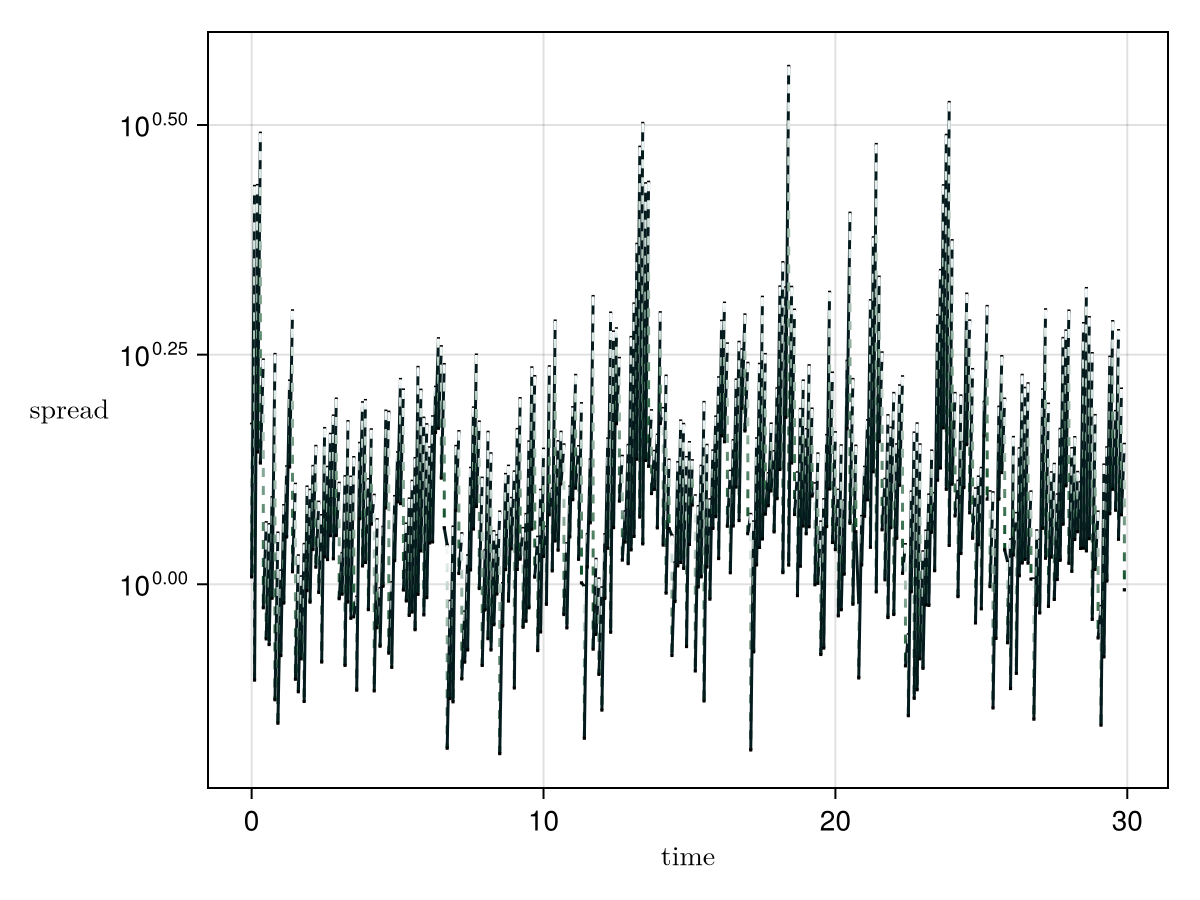

In [15]:
if plot_initial_metrics
    figs_spread[1]
end

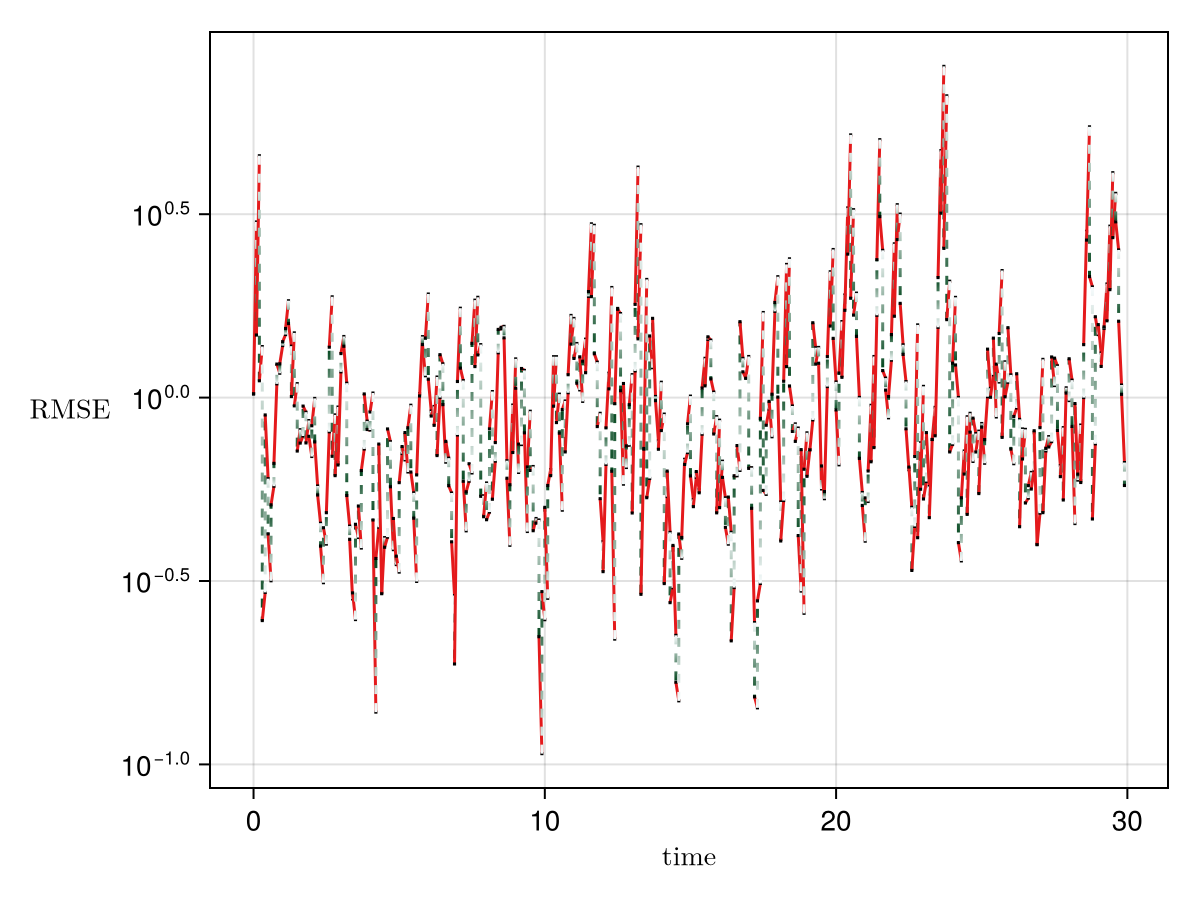

In [16]:
if plot_initial_metrics
    figs_rmse[1]
end

Plot the ensemble mean.

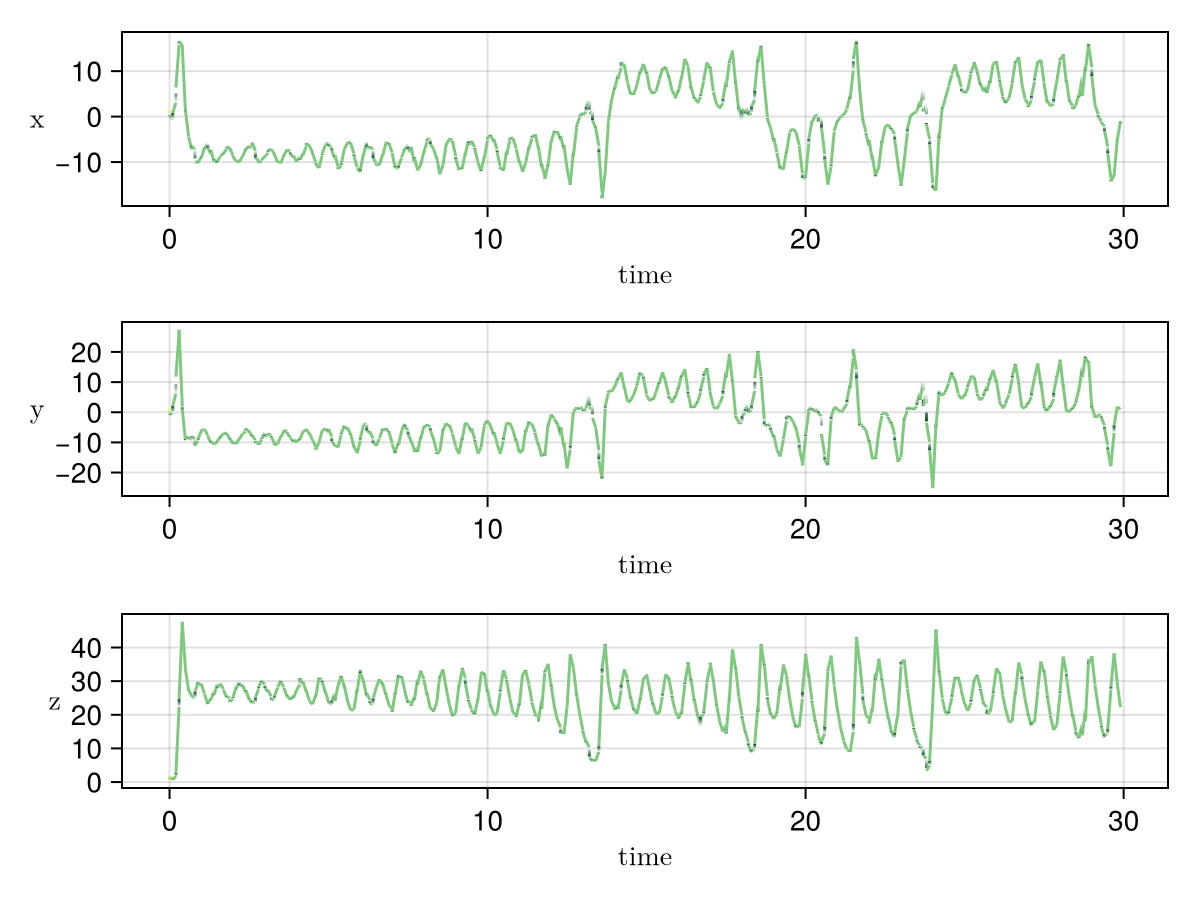

In [17]:
if !(@isdefined plot_initial_ensemble_mean)
    plot_initial_ensemble_mean = true
end
if plot_initial_ensemble_mean
    figs = let metrics = metrics_initial
        cut = Colon()

        ts_gt = observation_times
        xs_gt = view(ground_truth_states_vec, 1, :)
        ys_gt = view(ground_truth_states_vec, 2, :)
        zs_gt = view(ground_truth_states_vec, 3, :)

        gt_kwargs = (;
            color=("#d95f02", 0.5),
            marker='.',
            markersize=15,
            markercolor=(:yellow, 0.5),
        )

        handler = function (fig)
            for ax in fig.content
                if isa(ax, Axis)
                    t0 = minimum(ax.scene.plots[1].args[1][])
                    tf = maximum(ax.scene.plots[1].args[1][])
                    start = searchsortedfirst(ts_gt, t0)
                    finish = searchsortedfirst(ts_gt, tf)
                    if ax.ylabel[] == L"\text{x}"
                        scatterlines!(
                            ax,
                            ts_gt[start:finish],
                            xs_gt[start:finish];
                            gt_kwargs...,
                        )
                    elseif ax.ylabel[] == L"\text{y}"
                        scatterlines!(
                            ax,
                            ts_gt[start:finish],
                            ys_gt[start:finish];
                            gt_kwargs...,
                        )
                    elseif ax.ylabel[] == L"\text{z}"
                        scatterlines!(
                            ax,
                            ts_gt[start:finish],
                            zs_gt[start:finish];
                            gt_kwargs...,
                        )
                    end
                end
            end
        end
        plot_kwargs = (;
            handler,
            max_dt=50,
            color="#7fc97f",
            marker='.',
            markersize=0,
            markercolor=:black,
            connect=(; linestyle=:dash, color=[1, 2], colormap=:BuGn, markersize=0),
        )
        figs = plot_state_over_time(
            metrics.ts[cut], metrics.means_vec[:, cut]; plot_kwargs...
        )
    end
    figs[1]
end

And so everything is great!

Note that this cleanup only needs to be run in automated contexts.
The unregistered packages can cause issues.

In [18]:
try
    Pkg.rm("Lorenz63")
    Pkg.rm("EnsembleKalmanFilters")
    Pkg.rm("NormalizingFlowFilters")
catch e
    @warn e
end

    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Project.toml`
  [72db8b11] - Lorenz63 v0.1.0 `https://github.com/milankl/Lorenz63.jl#15220a7#master`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Manifest.toml`
  [72db8b11] - Lorenz63 v0.1.0 `https://github.com/milankl/Lorenz63.jl#15220a7#master`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Project.toml`
  [489b957c] - EnsembleKalmanFilters v0.0.1 `https://github.com/DataAssimilation/EnsembleKalmanFilters.jl#main`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Manifest.toml`
  [489b957c] - EnsembleKalmanFilters v0.0.1 `https://github.com/DataAssimilation/EnsembleKalmanFilters.jl#main`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Project.toml`
  [bdff3154] - NormalizingFlowFilters v0.0.1 `https://github.com/DataAssimilation/NormalizingFlowFilters.jl#main`
    Updating `~/work/Ensembles.jl/Ensembles.jl/examples/lorenz63/Manifest.toml`
  [4fba245c

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*